# LLE clustering for SL and Brown and Bruzual Charlot PCA coefficients


- author : Sylvie Dagoret-Campagne
- affiliation  : IJCLab
- creation date : 2023/01/18
- last update : 2023-01-18


- https://github.com/JospehCeh/PhotoZ_PhD/tree/u/dagoret


## scikit-learn : manifold learning


- https://scikit-learn.org/stable/modules/manifold.html#manifold-learning


 - https://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html#sphx-glr-auto-examples-manifold-plot-compare-methods-py

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#from sklearn_som.som import SOM
#from minisom import MiniSom
#from sklearn.decomposition import PCA

from sklearn import manifold

/Users/dagoret/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
%matplotlib inline
import os
import numpy as np
from matplotlib.ticker import FormatStrFormatter, NullFormatter
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd
import seaborn as sns 
import itertools
sns.set_style("white")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette(["#9b59b6", "#95a5a6", 
                                   "#e74c3c", "#3498db", 
                                   "#34495e", "#2ecc71"]))
import copy
from itertools import cycle

In [4]:
from astropy.io import fits
import pickle

In [5]:
# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.left': True,
          'figure.figsize': [18, 10],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)


In [6]:
def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

## Start

In [7]:
cwd=os.path.abspath("")
main_dir = cwd
print(f"notebook current executing path : {cwd}")

notebook current executing path : /Users/dagoret/MacOSX/GitHub/LSST/PhotoZ_PhD/LLE


## Config

### Check convergence

In [8]:
FLAG_CHECK_CONVERGENCE = False   # check if the number of iteration is OK
FLAG_VIEW_CLUSTERING = False     # View the result of clustering
FLAG_PCA_ONCLUSTERS = False       # Do PCA inside each cluster

## Read input file

### Choose the type of input:

- infile_idx=0 : StarLight
- infile_idx=1 : Brown
- infile_idx=2 : Bruzual-Charlot

In [9]:
all_filenames = ['datatools/spectra_SL_data.fits',
                 'datatools/spectra_Brown_data.fits',
                 'datatools/spectra_BruzualCharlot_data.fits']
all_filenames_labels = ["StarLight","Brown","Bruzual-Charlot"]
all_filenames_tags = ["SL","BR","BC"]


# choose the SED type
infile_idx=0

the_filename_label = all_filenames_labels[infile_idx]
the_filename_tag = all_filenames_tags[infile_idx]

filename = all_filenames[infile_idx]
hdu = fits.open(filename)
hdu.info()

Filename: datatools/spectra_SL_data.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      11   (6362, 553)   float64   


In [10]:
data_in=hdu[0].data
hdr_in = hdu[0].header

## Read Decode data

In [11]:
wavelengths = data_in[0,1:] 
flambdas_average = data_in[1,1:] 
flambdas_std = data_in[2,1:] 
spec = data_in[3:,1:] 
all_numbers = data_in[3:,0] 

In [12]:
NSED = data_in.shape[0]-3
NWL = data_in.shape[1]-1

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_99163/1517666208.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])


Text(0.5, 0, '$\\lambda (\\AA)$')

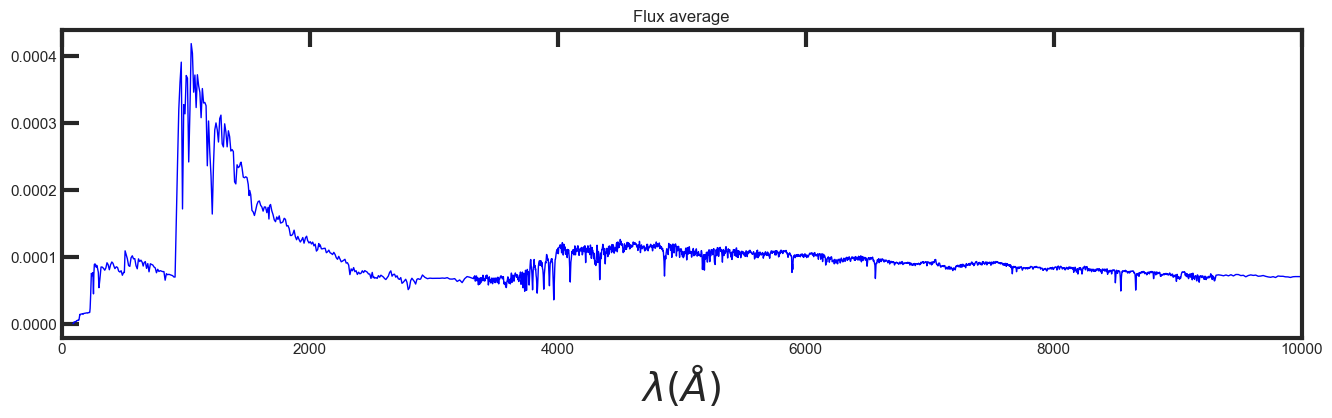

In [13]:
plt.figure(figsize=(16,4))
plt.plot(wavelengths,flambdas_average,'b-',lw=1)
plt.xlim(0.,10000.)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
plt.title("Flux average")
plt.xlabel("$\lambda (\AA)$")


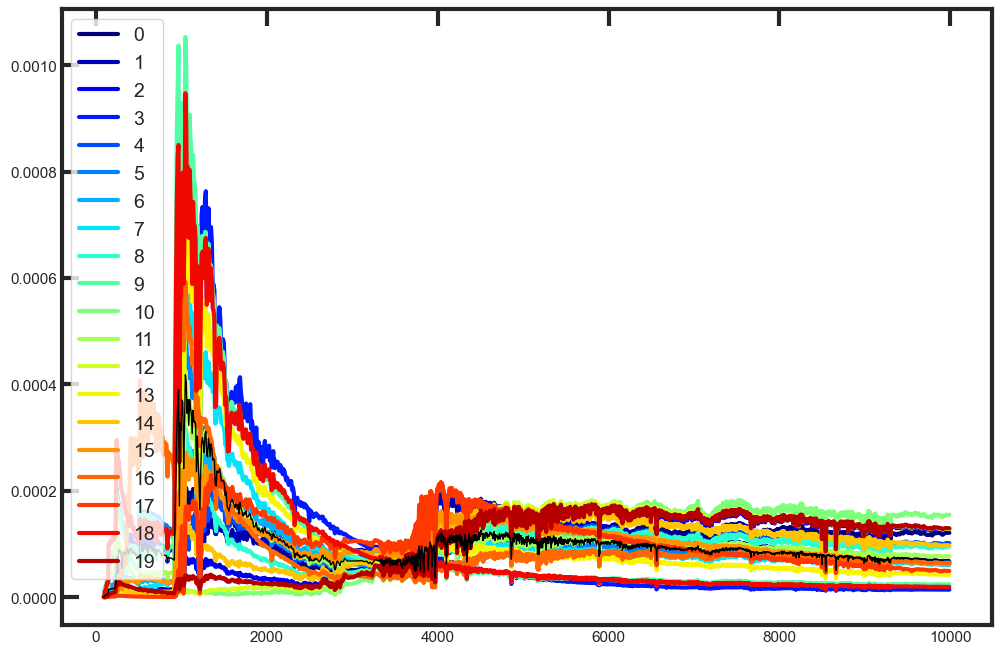

In [14]:
# wavelength bin colors
NTOPLOT=20
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NTOPLOT)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NTOPLOT), alpha=1)


fig = plt.figure(figsize=(12, 8))

for idx in np.arange(20):
    plt.plot(wavelengths,spec[idx,:],color=all_colors[idx],label=str(idx))

plt.legend()
spec_mean = spec.mean(0)
plt.plot(wavelengths,spec_mean,"k-",lw=1)
#plt.ylim(0,50.)

# Normalize the data

- I think one should not standardize PCA coefficients

In [15]:
X = copy.deepcopy(spec)
#X = copy.deepcopy((spec - np.mean(spec, axis=0)) / np.std(spec, axis=0))

### Locally Linear Embeddings

Locally linear embedding (LLE) can be thought of as a series of local Principal Component Analyses which are globally compared to find the best non-linear embedding.


## manifold learning

In [16]:
n_neighbors = 12  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold

In [17]:
params = {
    "n_neighbors": n_neighbors,
    "n_components": n_components,
    "eigen_solver": "auto",
    "random_state": 0,
}

lle_standard = manifold.LocallyLinearEmbedding(method="standard", **params)
X_standard = lle_standard.fit_transform(X)

lle_ltsa = manifold.LocallyLinearEmbedding(method="ltsa", **params)
X_ltsa = lle_ltsa.fit_transform(X)

lle_hessian = manifold.LocallyLinearEmbedding(method="hessian", **params)
X_hessian = lle_hessian.fit_transform(X)

lle_mod = manifold.LocallyLinearEmbedding(method="modified", **params)
X_mod = lle_mod.fit_transform(X)

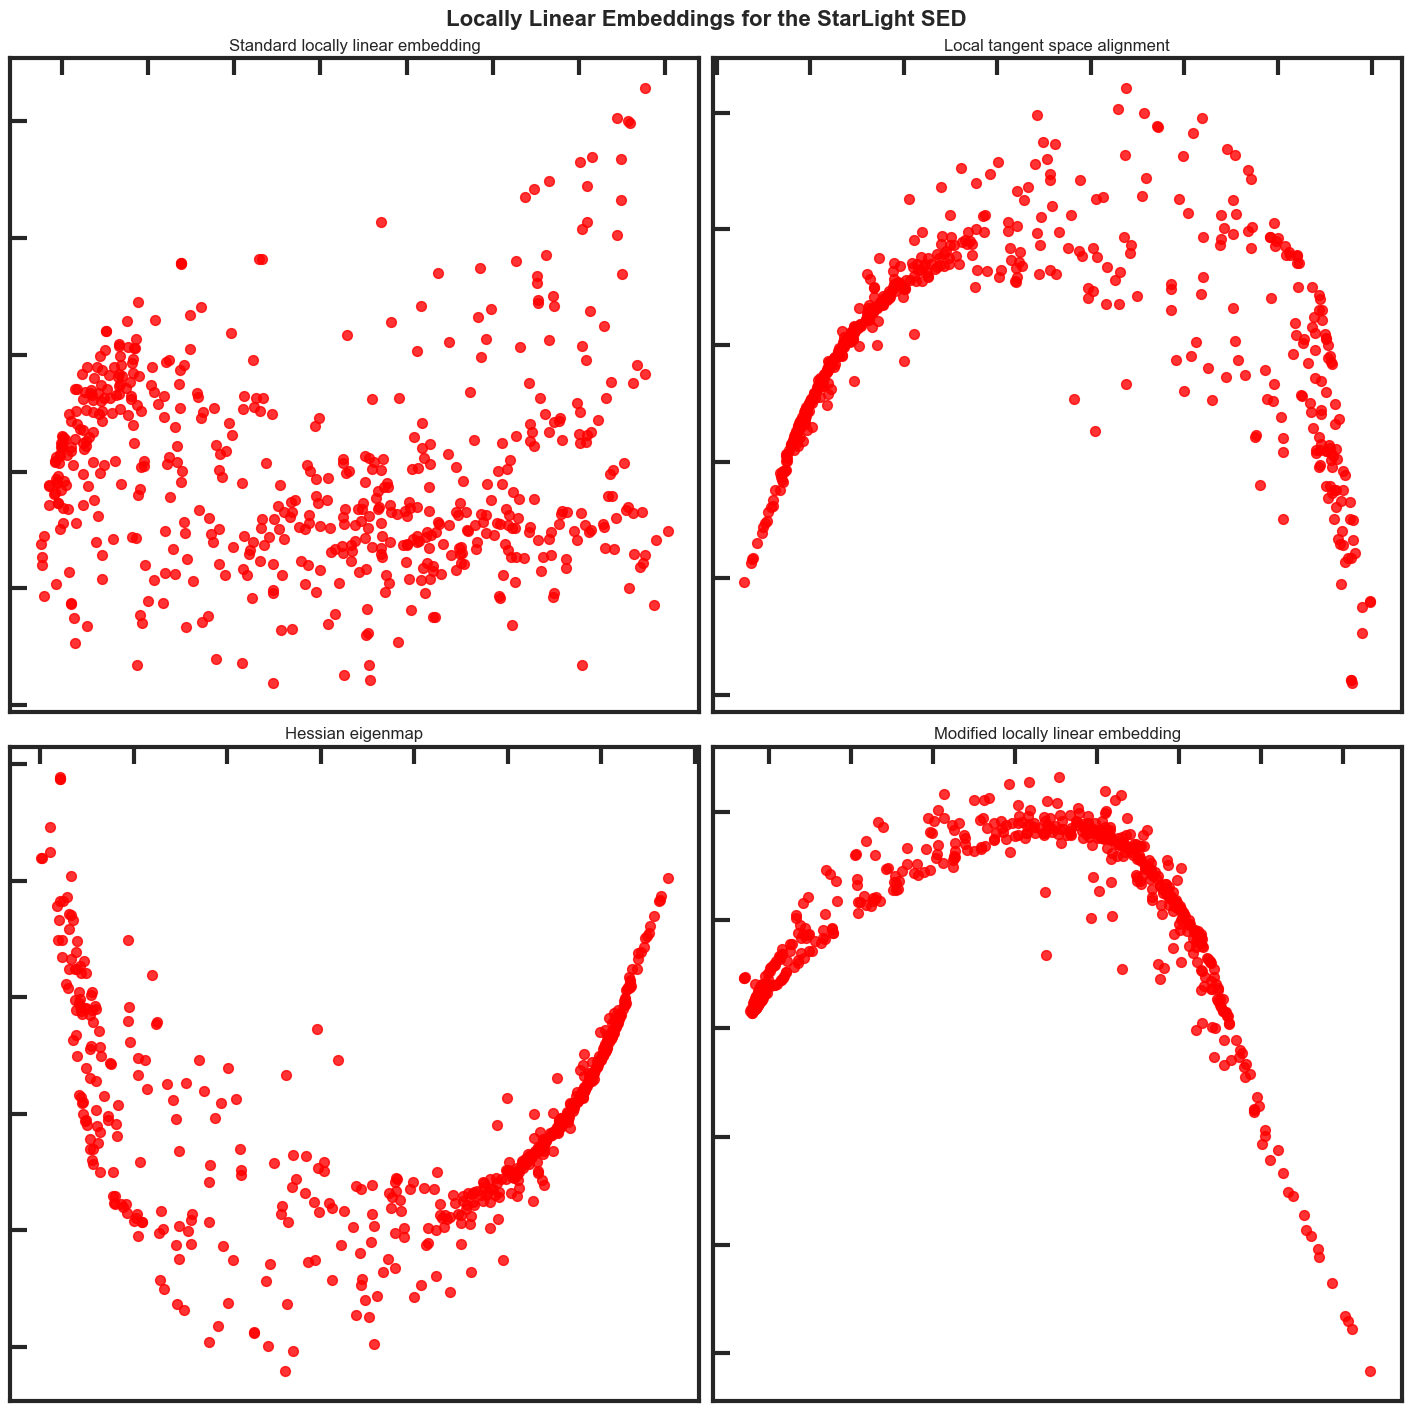

In [18]:
fig, axs = plt.subplots(
    nrows=2, ncols=2, figsize=(14, 14), facecolor="white", constrained_layout=True
)

the_title = f"Locally Linear Embeddings for the {the_filename_label} SED" 
fig.suptitle(the_title, size=16,fontweight='bold')

lle_methods = [
    ("Standard locally linear embedding", X_standard),
    ("Local tangent space alignment", X_ltsa),
    ("Hessian eigenmap", X_hessian),
    ("Modified locally linear embedding", X_mod),
]
for ax, method in zip(axs.flat, lle_methods):
    name, points = method
    add_2d_scatter(ax, points,'r', name)

plt.show()